<h1><center><font size="25">Probabilistic forecasting with machine learning</font></center></h1>

**Autores**: Joaquin Amat Rodrigo, Javier Escobar Ortiz

**Fecha**: 03-12-2024

<br>

<div style="text-align: center;">
    <img src="https://github.com/JoaquinAmatRodrigo/skforecast/raw/master/docs/img/banner-landing-page-skforecast.png" style="display: block; margin: 0 auto;">
</div>

## Libraries

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_distribution
from pprint import pprint

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from scipy.stats import norm

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

### Data

In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name='bike_sharing_extended_features')
data.head(2)

bike_sharing_extended_features
------------------------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, the dataset
was enriched by introducing supplementary features. Addition includes calendar-
based variables (day of the week, hour of the day, month, etc.), indicators for
sunlight, incorporation of rolling temperature averages, and the creation of
polynomial features generated from variable pairs. All cyclic variables are
encoded using sine and cosine functions to ensure accurate representation.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17352, 90)


,users,weather,month_sin,month_cos,week_of_year_sin,week_of_year_cos,week_day_sin,week_day_cos,hour_day_sin,hour_day_cos,...,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day,holiday_previous_day,holiday_next_day,temp,holiday
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-08 00:00:00,25.0,mist,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.258819,0.965926,...,8.063334,10.127976,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0
2011-01-08 01:00:00,16.0,mist,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.500000,0.866025,...,8.029166,10.113334,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0


In [3]:
# One hot encoding of categorical variables
# ==============================================================================
encoder = ColumnTransformer(
              [('one_hot_encoder', OneHotEncoder(sparse_output=False), ['weather'])],
              remainder='passthrough',
              verbose_feature_names_out=False
          ).set_output(transform="pandas")
data = encoder.fit_transform(data)

In [4]:
# Exxogenous features
# ==============================================================================
exog_features = [
    'weather_clear', 'weather_mist', 'weather_rain', 'month_sin', 'month_cos',
    'week_of_year_sin', 'week_of_year_cos', 'week_day_sin', 'week_day_cos',
    'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'temp'
]
data = data[['users'] + exog_features]

In [5]:
# Split train-validation-test
# ==============================================================================
data = data.loc['2011-05-30 23:59:00':, :]
end_train = '2012-08-30 23:59:00'
end_validation = '2012-11-15 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-05-31 00:00:00 --- 2012-08-30 23:00:00  (n=10992)
Dates validacion : 2012-08-31 00:00:00 --- 2012-11-15 23:00:00  (n=1848)
Dates test       : 2012-11-16 00:00:00 --- 2012-12-30 23:00:00  (n=1080)


### Graphic exploration

In [6]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['users'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['users'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['users'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Number of users',
    xaxis_title="Time",
    yaxis_title="Users",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### In sample residuals

A [recursive-multi-step forecaster](https://skforecast.org/latest/user_guides/autoregresive-forecaster.html) is trained and its [hyperparameters optimized](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection). Then, prediction intervals based on bootstrapped residuals are estimated.

In [7]:
# Create forecaster and hyperparameters search
# ==============================================================================
# Forecaster
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 7
             )

# Lags used as predictors
lags_grid = [24, 48, (1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, 364*24, 365*24)]

# Folds
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(data[:end_train]),
        refit              = False,
     )

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', lags_grid),
        'n_estimators'    : trial.suggest_int('n_estimators', 200, 800, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 8, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.8, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 100, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1)
    }

    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster    = forecaster,
                                   y             = data.loc[:end_validation, 'users'],
                                   exog          = data.loc[:end_validation, exog_features],
                                   cv            = cv,
                                   metric        = 'mean_absolute_error',
                                   search_space  = search_space,
                                   n_trials      = 20,
                                   random_state  = 123,
                                   return_best   = True,
                                   n_jobs        = 'auto',
                                   verbose       = False,
                                   show_progress = True
                               )

best_params = results_search['params'].iloc[0]
best_lags   = results_search['lags'].iloc[0]

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [   1    2    3   23   24   25   47   48   49   71   72   73 8736 8760] 
  Parameters: {'n_estimators': 300, 'max_depth': 5, 'min_data_in_leaf': 25, 'learning_rate': 0.10794173876361574, 'feature_fraction': 0.6, 'max_bin': 75, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
  Backtesting metric: 55.511717405682845


Once the best hyperparameters have been selected, the `backtesting_forecaster()` function is used to generate the prediction intervals for the entire test set. 

+ The `interval` argument indicates the desired coverage probability of the prediction intervals. In this case, `interval` is set to `[10, 90]`, which means that the prediction intervals are calculated for the 10th and 90th percentiles, resulting in a theoretical coverage probability of 80%. 

+ The `n_boot` argument is used to specify the number of bootstrap samples to be used in estimating the prediction intervals. The larger the number of samples, the more accurate the prediction intervals will be, but the longer the calculation will take.

By default, intervals are calculated using in-sample residuals (residuals from the training set). However, this can result in intervals that are too narrow (overly optimistic).

In [8]:
# Backtesting with prediction intervals in test data using in-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(data.loc[:end_validation]),
        refit              = False,
    )
metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],
                          n_boot                  = 250,
                          use_in_sample_residuals = True,
                          use_binned_residuals    = False,
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )
display(metric)
predictions.head(5)

  0%|          | 0/45 [00:00<?, ?it/s]

,mean_absolute_error
0,50.169882


,pred,lower_bound,upper_bound
2012-11-16 00:00:00,72.647035,47.030040,91.508213
2012-11-16 01:00:00,27.910501,5.234677,56.415968
2012-11-16 02:00:00,12.652874,-8.189360,37.630442
2012-11-16 03:00:00,7.294529,-15.905327,37.896229
2012-11-16 04:00:00,5.797888,-10.989871,37.238566


In [9]:
# Function to plot predicted intervals
# ======================================================================================
def plot_predicted_intervals(
    predictions: pd.DataFrame,
    y_true: pd.DataFrame,
    target_variable: str,
    initial_x_zoom: list=None,
    title: str=None,
    xaxis_title: str=None,
    yaxis_title: str=None,
):
    """
    Plot predicted intervals vs real values

    Parameters
    ----------
    predictions : pandas DataFrame
        Predicted values and intervals.
    y_true : pandas DataFrame
        Real values of target variable.
    target_variable : str
        Name of target variable.
    initial_x_zoom : list, default `None`
        Initial zoom of x-axis, by default None.
    title : str, default `None`
        Title of the plot, by default None.
    xaxis_title : str, default `None`
        Title of x-axis, by default None.
    yaxis_title : str, default `None`
        Title of y-axis, by default None.
    
    """

    fig = go.Figure([
        go.Scatter(name='Prediction', x=predictions.index, y=predictions['pred'], mode='lines'),
        go.Scatter(name='Real value', x=y_true.index, y=y_true[target_variable], mode='lines'),
        go.Scatter(
            name='Upper Bound', x=predictions.index, y=predictions['upper_bound'],
            mode='lines', marker=dict(color="#444"), line=dict(width=0), showlegend=False
        ),
        go.Scatter(
            name='Lower Bound', x=predictions.index, y=predictions['lower_bound'],
            marker=dict(color="#444"), line=dict(width=0), mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
        )
    ])
    fig.update_layout(
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        width=800,
        height=400,
        margin=dict(l=20, r=20, t=35, b=20),
        hovermode="x",
        xaxis=dict(range=initial_x_zoom),
        legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
    )
    fig.show()


def empirical_coverage(y, lower_bound, upper_bound):
    """
    Calculate coverage of a given interval
    """
    return np.mean(np.logical_and(y >= lower_bound, y <= upper_bound))

In [10]:
# Plot intervals (with zoom ['2012-12-01', '2012-12-20'])
# ==============================================================================
plot_predicted_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "users",
    initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "users",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = empirical_coverage(
                y           = data.loc[end_validation:, 'users'],
                lower_bound = predictions["lower_bound"], 
                upper_bound = predictions["upper_bound"]
            )
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 56.85 %
Area of the interval: 77204.7


The prediction intervals exhibit overconfidence as they tend to be excessively narrow, resulting in a true coverage that falls below the nominal coverage. This phenomenon arises from the tendency of in-sample residuals to often overestimate the predictive capacity of the model.

### Out sample residuals (non-conditioned on predicted values)

The `set_out_sample_residuals()` method is used to specify out-sample residuals computed with a validation set through backtesting. Once the new residuals have been added to the forecaster, set `use_in_sample_residuals` to `False` use them.

In [11]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(data.loc[:end_train]),
        refit              = False,
    )
_, predictions_val = backtesting_forecaster(
                         forecaster    = forecaster,
                         y             = data.loc[:end_validation, 'users'],
                         exog          = data.loc[:end_validation, exog_features],
                         cv            = cv,
                         metric        = 'mean_absolute_error',
                         n_jobs        = 'auto',
                         verbose       = False,
                         show_progress = True
                     )

  0%|          | 0/77 [00:00<?, ?it/s]

positive    1103
negative     745
Name: count, dtype: int64


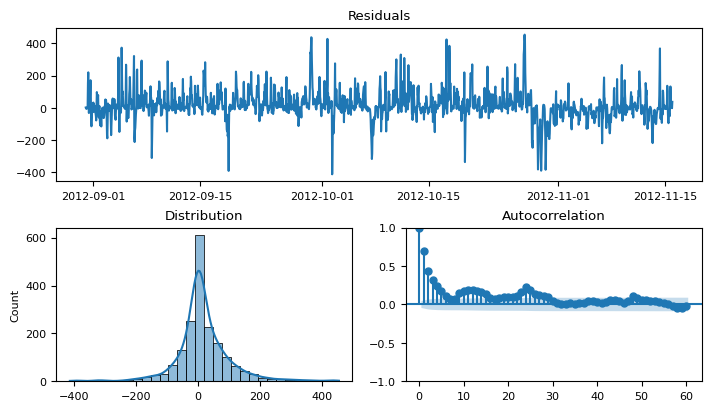

In [12]:
# Out-sample residuals distribution
# ==============================================================================
residuals = data.loc[predictions_val.index, 'users'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

In [13]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'users'],
    y_pred = predictions_val['pred']
)    

In [14]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(data.loc[:end_validation]),
        refit              = False,
    )
metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],
                          n_boot                  = 250,
                          use_in_sample_residuals = False, # Use out-sample residuals
                          use_binned_residuals    = False,
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )
predictions.head(5)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,72.647035,-5.781274,175.261296
2012-11-16 01:00:00,27.910501,-19.151577,148.396456
2012-11-16 02:00:00,12.652874,-29.529170,148.716762
2012-11-16 03:00:00,7.294529,-28.602086,179.288057
2012-11-16 04:00:00,5.797888,-20.644728,186.125135


In [15]:
# Plot intervals (with zoom ['2012-12-01', '2012-12-20'])
# ==============================================================================
plot_predicted_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "users",
    initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "users",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = empirical_coverage(
                y           = data.loc[end_validation:, 'users'],
                lower_bound = predictions["lower_bound"], 
                upper_bound = predictions["upper_bound"]
            )
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 80.74 %
Area of the interval: 256193.95


The prediction intervals derived from the out-of-sample residuals are considerably wider than those based on the in-sample residuals, resulting in an empirical coverage closer to the nominal coverage. Looking at the plot, it's clear that the intervals are particularly wide at low predicted values, suggesting that the model struggles to accurately capture the uncertainty in its predictions at these lower values.

### Out sample residuals (conditioned on predicted values)

The bootstrapping process assumes that the residuals are independently distributed so that they can be used independently of the predicted value. In reality, this is rarely true; in most cases, the magnitude of the residuals is correlated with the magnitude of the predicted value. In this case, for example, one would hardly expect the error to be the same when the predicted number of users is close to zero as when it is in the hundreds.

To account for the dependence between the residuals and the predicted values, skforecast allows to **partition the residuals into *K* bins**, where each bin is associated with a range of predicted values. Using this strategy, the bootstrapping process samples the residuals from different bins depending on the predicted value, which can improve the coverage of the interval while adjusting the width if necessary, allowing the model to **better distribute the uncertainty of its predictions**.

To enable the forecaster to bin the out-sample residuals, the predicted values are passed to the `set_out_sample_residuals()` method in addition to the residuals. Internally, skforecast uses a [`QuantileBinner`](../api/preprocessing.html#skforecast.preprocessing.preprocessing.QuantileBinner) class to bin data into quantile-based bins using `numpy.percentile`. This class is similar to [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html) but faster for binning data into quantile-based bins. Bin intervals are defined following the convention: bins[i-1] <= x < bins[i]. The binning process can be adjusted using the argument `binner_kwargs` of the Forecaster object.

In [16]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor     = LGBMRegressor(random_state=15926, verbose=-1, **best_params),
                 lags          = best_lags,
                 binner_kwargs = {'n_bins': 15}   
             )

forecaster.fit(
    y     = data.loc[:end_validation, 'users'],
    exog  = data.loc[:end_validation, exog_features]
)

During the training process, the forecaster uses the in-sample predictions to define the intervals at which the residuals are stored, depending on the predicted value to which they are related. Although not used in this example, the in-sample residuals are divided into bins and stored in the `in_sample_residuals_by_bin_` attribute.

In [17]:
# Intervals of the residual bins
# ==============================================================================
pprint(forecaster.binner_intervals_)

{0.0: (-1.1605571978908278, 10.051604843148704),
 1.0: (10.051604843148704, 22.714898015634944),
 2.0: (22.714898015634944, 43.59110028232778),
 3.0: (43.59110028232778, 94.32558543596477),
 4.0: (94.32558543596477, 145.61466421263225),
 5.0: (145.61466421263225, 186.37655392097258),
 6.0: (186.37655392097258, 228.70603128934513),
 7.0: (228.70603128934513, 263.1241277304725),
 8.0: (263.1241277304725, 298.11555513972024),
 9.0: (298.11555513972024, 339.17249174344533),
 10.0: (339.17249174344533, 399.4530478594139),
 11.0: (399.4530478594139, 471.94600511064976),
 12.0: (471.94600511064976, 554.6823749797009),
 13.0: (554.6823749797009, 683.0374906726976),
 14.0: (683.0374906726976, 980.1908225561352)}


Next, the out-of-sample residuals are saved within the forecaster. To manage memory efficiently, a maximum of *10,000//n_bins* residuals are stored for each bin.

In [18]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'users'],
    y_pred = predictions_val['pred']
)

In [19]:
# Number of residuals by bin
# ==============================================================================
for k, v in forecaster.out_sample_residuals_by_bin_.items():
    print(f" Bin {k}: n={len(v)}")

 Bin 0: n=154
 Bin 1: n=115
 Bin 2: n=116
 Bin 3: n=108
 Bin 4: n=123
 Bin 5: n=133
 Bin 6: n=119
 Bin 7: n=145
 Bin 8: n=145
 Bin 9: n=154
 Bin 10: n=115
 Bin 11: n=118
 Bin 12: n=127
 Bin 13: n=107
 Bin 14: n=69


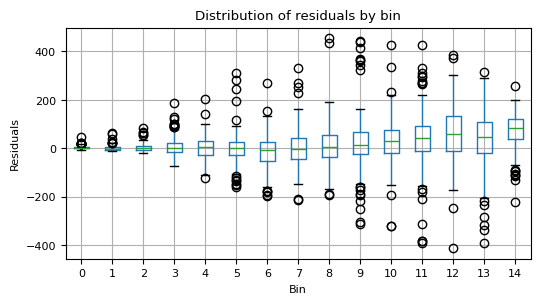

In [20]:
# Distribution of the residual by bin
# ==============================================================================
out_sample_residuals_by_bin_df = pd.DataFrame(
    dict([(k, pd.Series(v)) for k, v in forecaster.out_sample_residuals_by_bin_.items()])
)
fig, ax = plt.subplots(figsize=(6, 3))
out_sample_residuals_by_bin_df.boxplot(ax=ax)
ax.set_title("Distribution of residuals by bin")
ax.set_xlabel("Bin")
ax.set_ylabel("Residuals");

The box plots illustrate how both the spread and magnitude of residuals vary with the predicted values. For instance, in bin 0, residuals remain within an absolute value of 100, whereas in bins above 5, they frequently exceed this threshold.

Finally, the prediction intervals for the test data are estimated using the backtesting process, with out-of-sample residuals conditioned on the predicted values.

In [21]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False,
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],
                          n_boot                  = 250,
                          use_in_sample_residuals = False, # Use out-sample residuals
                          use_binned_residuals    = True,  # Use binned residuals
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )
predictions.head(5)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,72.647035,36.716578,151.505586
2012-11-16 01:00:00,27.910501,12.550630,84.249515
2012-11-16 02:00:00,12.652874,6.101187,49.985877
2012-11-16 03:00:00,7.294529,4.798375,25.070247
2012-11-16 04:00:00,5.797888,5.472404,25.379916


In [22]:
# Plot intervals (with zoom ['2012-12-01', '2012-12-20'])
# ==============================================================================
plot_predicted_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "users",
    initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "users",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = empirical_coverage(
                y           = data.loc[end_validation:, 'users'],
                lower_bound = predictions["lower_bound"], 
                upper_bound = predictions["upper_bound"]
            )
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 76.76 %
Area of the interval: 218228.66


When using out-of-sample residuals conditioned on the predicted value, the interval has a coverage close to the expected value (80%) while reducing its width. The model is able to better distribute the uncertainty in its predictions.

### Predict bootstraping, quantile and distribution

The previous sections have demonstrated the use of the backtesting process to estimate the prediction interval over a given period of time. The goal is to mimic the behavior of the model in production by running predictions at regular intervals, incrementally updating the input data.

Alternatively, it is possible to run a single prediction that forecasts *N* steps ahead without going through the entire backtesting process. In such cases, skforecast provides four different methods: `predict_bootstrapping`, `predict_interval`, `predict_quantile` and `predict_distribution`.

**Predict Bootstraping** 

The `predict_bootstrapping` method performs the `n_boot` bootstrapping iterations that generate the alternative prediction paths. These are the underlying values used to compute the intervals, quantiles, and distributions.

In [23]:
# Fit forecaster
# ==============================================================================
forecaster.fit(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features]
)

In [24]:
# Predict 10 different forecasting sequences of 7 steps each using bootstrapping
# ==============================================================================
boot_predictions = forecaster.predict_bootstrapping(
                       exog   = data_test[exog_features],
                       steps  = 7,
                       n_boot = 25
                   )
boot_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_15,pred_boot_16,pred_boot_17,pred_boot_18,pred_boot_19,pred_boot_20,pred_boot_21,pred_boot_22,pred_boot_23,pred_boot_24
2012-11-16 00:00:00,70.517121,101.063813,77.462039,68.134674,74.415891,68.185299,59.718977,71.174600,85.474578,84.809743,...,98.805871,52.571170,47.831242,57.878506,102.482547,70.400782,83.919594,73.052421,59.992594,73.389063
2012-11-16 01:00:00,44.097987,30.723679,36.208313,56.061323,36.590612,31.299697,9.721873,47.825904,-0.177614,-14.661356,...,39.967767,26.387689,16.821526,23.192047,39.640229,11.430646,29.440645,49.769999,46.493081,26.438067
2012-11-16 02:00:00,41.096888,11.469296,25.709138,-29.402627,3.846010,16.083769,1.060935,12.061020,5.196004,16.020413,...,-1.124383,14.544889,39.197324,12.349387,30.950606,30.866793,-18.386768,-6.400440,-7.744918,9.327434
2012-11-16 03:00:00,16.568763,15.579944,10.926792,-22.632703,-23.016677,3.296021,6.428537,23.558528,-20.470201,109.173095,...,37.677544,6.921703,38.724452,13.579431,-36.508401,15.537699,30.205147,20.738906,-11.463739,-7.119305
2012-11-16 04:00:00,19.360655,16.167840,-35.531262,23.559550,30.514463,5.221401,13.328213,-1.277220,-18.547317,87.018580,...,-0.203937,7.604123,-2.073781,12.039539,17.974969,-10.099835,-6.996446,-19.533493,9.586785,10.609952
2012-11-16 05:00:00,11.186855,47.704979,-53.718683,38.409483,43.073559,4.428013,33.987120,62.330454,22.096377,25.389995,...,62.184303,11.868985,20.816075,47.889209,30.420284,22.831788,53.312810,7.779963,45.317621,34.709875
2012-11-16 06:00:00,105.057350,171.059905,116.220845,165.712442,157.969064,113.419134,125.698163,108.617440,108.371925,108.143015,...,109.646748,127.774275,68.256454,71.047641,110.732610,108.563321,71.454449,95.462673,151.806080,114.545621


A ridge plot is a useful way to visualize the uncertainty of a forecasting model. This plot estimates a kernel density for each step by using the bootstrapped predictions.

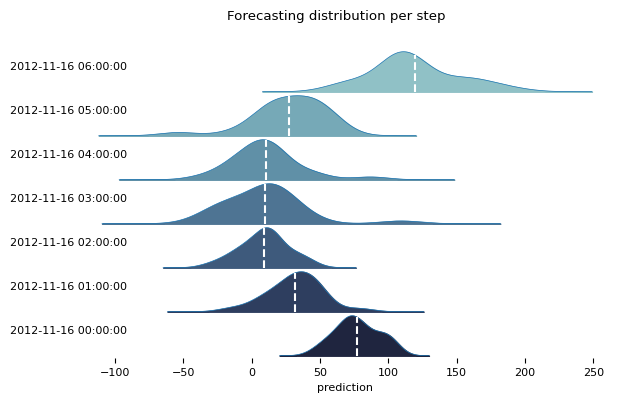

In [25]:
# Ridge plot of bootstrapping predictions
# ==============================================================================
_ = plot_prediction_distribution(boot_predictions, figsize=(7, 4))

**Predict Interval**

In most cases, the user is interested in a specific interval rather than the entire bootstrapping simulation matrix. To address this need, skforecast provides the `predict_interval` method. This method internally uses `predict_bootstrapping` to obtain the bootstrapping matrix and estimates the upper and lower quantiles for each step, thus providing the user with the desired prediction intervals.

In [26]:
# Predict intervals for next 7 steps, quantiles 10th and 90th
# ==============================================================================
predictions = forecaster.predict_interval(
                  exog     = data_test[exog_features],
                  steps    = 7,
                  interval = [10, 90],
                  n_boot   = 150
              )
predictions

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,72.647035,43.834919,96.460458
2012-11-16 01:00:00,27.910501,7.381703,59.078473
2012-11-16 02:00:00,12.652874,-15.930935,41.968756
2012-11-16 03:00:00,7.294529,-15.355917,37.612984
2012-11-16 04:00:00,5.797888,-12.419745,43.230960
2012-11-16 05:00:00,32.934977,15.511356,64.718078
2012-11-16 06:00:00,128.903108,88.043579,170.376929


**Predict Quantile**

This method operates identically to `predict_interval`, with the added feature of enabling users to define a specific list of quantiles for estimation at each step. It's important to remember that these quantiles should be specified within the range of 0 to 1.

In [27]:
# Predict quantiles for next 7 steps, quantiles 5th, 25th, 75th and 95th
# ==============================================================================
predictions = forecaster.predict_quantiles(
                  exog      = data_test[exog_features],
                  steps     = 7,
                  n_boot    = 150,
                  quantiles = [0.05, 0.25, 0.75, 0.95],
              )
predictions

,q_0.05,q_0.25,q_0.75,q_0.95
2012-11-16 00:00:00,39.954339,57.936473,83.364807,100.944133
2012-11-16 01:00:00,-1.146027,19.745468,41.414716,68.522395
2012-11-16 02:00:00,-21.623890,-2.287945,21.364732,51.923301
2012-11-16 03:00:00,-25.898018,0.199725,23.356771,48.188896
2012-11-16 04:00:00,-26.815273,-0.746843,22.768530,56.703141
2012-11-16 05:00:00,5.349227,23.981837,49.926363,72.165511
2012-11-16 06:00:00,69.682651,103.437712,150.414735,182.646359


**Predict Distribution**

The intervals estimated so far are distribution-free, which means that no assumptions are made about a particular distribution. The `predict_dist` method in skforecast allows fitting a parametric distribution to the bootstrapped prediction samples obtained with `predict_bootstrapping`. This is useful when there is reason to believe that the forecast errors follow a particular distribution, such as the normal distribution or the student's t-distribution. The `predict_dist` method allows the user to specify any continuous distribution from the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) module.

In [28]:
# Predict the parameters of a normal distribution for the next 7 steps
# ==============================================================================
predictions = forecaster.predict_dist(
                  exog         = data_test[exog_features],
                  steps        = 7,
                  n_boot       = 150,
                  distribution = norm
              )
predictions

,loc,scale
2012-11-16 00:00:00,71.126022,21.570047
2012-11-16 01:00:00,30.360256,21.492875
2012-11-16 02:00:00,11.725704,22.666247
2012-11-16 03:00:00,11.266490,23.119505
2012-11-16 04:00:00,11.862316,27.440639
2012-11-16 05:00:00,38.024622,22.412431
2012-11-16 06:00:00,127.622756,36.993702


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-nc-sa.svg" /></a><br/>

This work by  Joaquín Amat Rodrigo and Javier Escobar Ortiz is licensed under a <a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/"> Attribution-NonCommercial-ShareAlike 4.0 International</a>.